In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load the CSV
df = pd.read_csv("paper_strength_test_data.csv")

# Preview the data
df.head()


,Batch,Process,Tensile_Strength,Tear_Strength,Burst_Strength
0,Batch_1,Old,24.174648,15.618520,32.852950
1,Batch_1,Old,27.052675,13.899808,31.776535
2,Batch_1,Old,21.983556,14.408636,32.706644
3,Batch_1,Old,23.606223,15.095798,31.712870
4,Batch_1,Old,25.033333,14.486649,31.042729


In [2]:
# Summary statistics
summary = df.groupby('Process')[['Tensile_Strength', 'Tear_Strength', 'Burst_Strength']].describe()
summary


Tensile_Strength                                             \
                   count       mean       std        min        25%   
Process                                                               
New                 60.0  26.935050  1.598996  23.023545  25.833694   
Old                240.0  25.156888  1.610846  21.017236  24.104329   

                                         Tear_Strength             ...  \
               50%        75%        max         count       mean  ...   
Process                                                            ...   
New      26.939592  28.084044  30.668628          60.0  16.341750  ...   
Old      25.204593  26.239358  29.175907         240.0  15.105288  ...   

                              Burst_Strength                                  \
               75%        max          count       mean       std        min   
Process                                                                        
New      17.068624  19.588032           60.0  34.910897  1.859195  30.145604   
Old      15.913990  18.809331          240.0  31.860472  1.737861  25.734544   

                                                     
               25%        50%        75%        max  
Process                                              
New      33.795815  34.740031  36.259811  39.273793  
Old      30.736889  31.926664  33.094572  36.570493  

[2 rows x 24 columns]

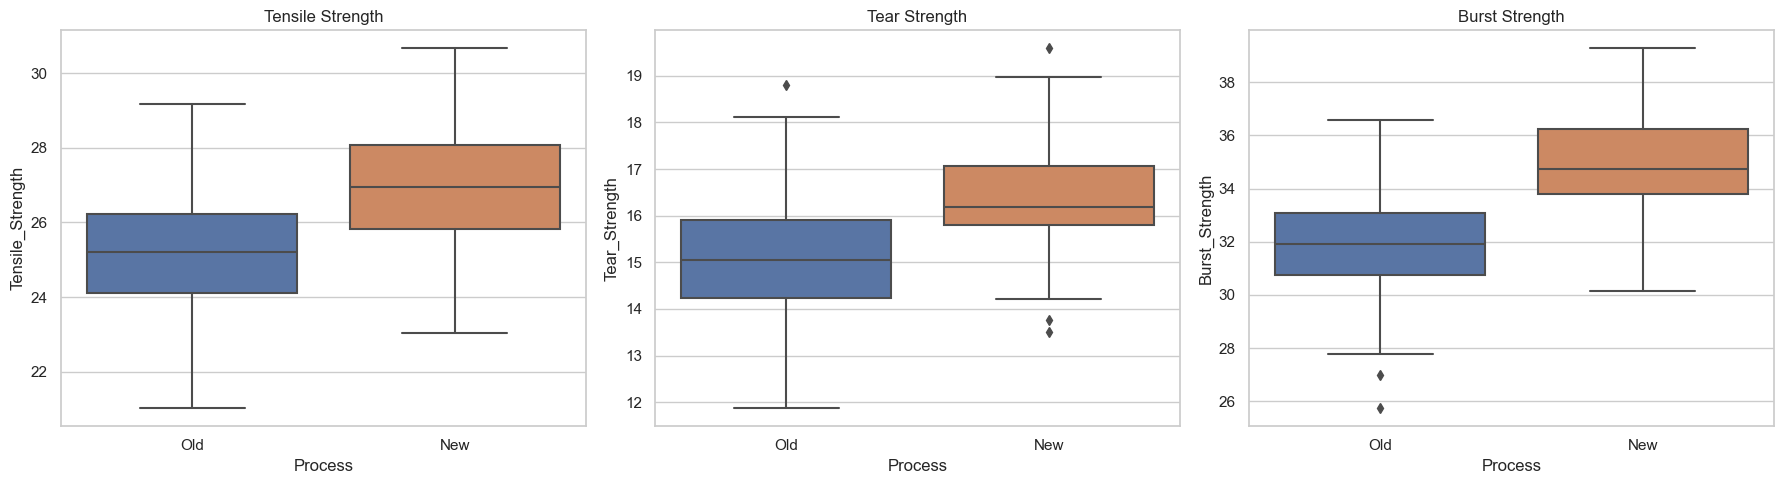

In [3]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Process', y='Tensile_Strength', data=df, ax=axes[0])
axes[0].set_title("Tensile Strength")

sns.boxplot(x='Process', y='Tear_Strength', data=df, ax=axes[1])
axes[1].set_title("Tear Strength")

sns.boxplot(x='Process', y='Burst_Strength', data=df, ax=axes[2])
axes[2].set_title("Burst Strength")

plt.tight_layout()
plt.show()


In [4]:
old = df[df['Process'] == 'Old']
new = df[df['Process'] == 'New']

def t_test(column):
    t_stat, p_val = stats.ttest_ind(old[column], new[column], equal_var=False)
    return pd.Series({'t-statistic': t_stat, 'p-value': p_val})

results = pd.DataFrame({col: t_test(col) for col in ['Tensile_Strength', 'Tear_Strength', 'Burst_Strength']}).T
results


,t-statistic,p-value
Tensile_Strength,-7.693068,1.620800e-11
Tear_Strength,-7.377852,7.138401e-11
Burst_Strength,-11.513567,3.796939e-19


In [5]:
def conf_int(data, column):
    mean = np.mean(data[column])
    std = np.std(data[column], ddof=1)
    n = len(data[column])
    moe = 1.96 * (std / np.sqrt(n))
    return pd.Series({'mean': mean, '95% CI Lower': mean - moe, '95% CI Upper': mean + moe})

conf_old = df[df['Process'] == 'Old'].apply(lambda col: conf_int(df[df['Process'] == 'Old'], col.name) if col.name in ['Tensile_Strength', 'Tear_Strength', 'Burst_Strength'] else None).dropna()
conf_new = df[df['Process'] == 'New'].apply(lambda col: conf_int(df[df['Process'] == 'New'], col.name) if col.name in ['Tensile_Strength', 'Tear_Strength', 'Burst_Strength'] else None).dropna()

conf_summary = pd.concat([conf_old.T, conf_new.T], keys=['Old', 'New'])
conf_summary


Old  Tensile_Strength    mean            25.156888
95% CI Lower    24.9...
     Tear_Strength       mean            15.105288
95% CI Lower    14.9...
     Burst_Strength      mean            31.860472
95% CI Lower    31.6...
New  Tensile_Strength    mean            26.935050
95% CI Lower    26.5...
     Tear_Strength       mean            16.341750
95% CI Lower    16.0...
     Burst_Strength      mean            34.910897
95% CI Lower    34.4...
dtype: object

In [6]:
anova_results = {}
for col in ['Tensile_Strength', 'Tear_Strength', 'Burst_Strength']:
    model = ols(f"{col} ~ C(Batch)", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[col] = anova_table

anova_results['Tensile_Strength']


,sum_sq,df,F,PR(>F)
C(Batch),169.422318,9.0,7.246419,1.657038e-09
Residual,753.360239,290.0,NaN,NaN


In [7]:
# Example spec threshold
specs = {'Tensile_Strength': 24, 'Tear_Strength': 14.5, 'Burst_Strength': 30}

spec_check = df.groupby("Batch")[['Tensile_Strength', 'Tear_Strength', 'Burst_Strength']].mean()
meets_spec = spec_check >= pd.Series(specs)
meets_spec


,Tensile_Strength,Tear_Strength,Burst_Strength
Batch,,,
Batch_1,True,True,True
Batch_10,True,False,True
Batch_2,True,True,True
Batch_3,True,True,True
Batch_4,True,True,True
Batch_5,True,True,True
Batch_6,True,True,True
Batch_7,True,True,True
Batch_8,True,True,True


In [8]:
# Estimate variation between batches vs within batches
for col in ['Tensile_Strength', 'Tear_Strength', 'Burst_Strength']:
    model = ols(f"{col} ~ C(Batch)", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"Gauge R&R proxy for {col}:\n", anova_table, "\n")


Gauge R&R proxy for Tensile_Strength:
               sum_sq     df         F        PR(>F)
C(Batch)  169.422318    9.0  7.246419  1.657038e-09
Residual  753.360239  290.0       NaN           NaN 

Gauge R&R proxy for Tear_Strength:
               sum_sq     df         F        PR(>F)
C(Batch)   97.557891    9.0  8.227707  6.649615e-11
Residual  382.066620  290.0       NaN           NaN 

Gauge R&R proxy for Burst_Strength:
               sum_sq     df          F        PR(>F)
C(Batch)  478.773241    9.0  17.263463  8.402387e-23
Residual  893.629384  290.0        NaN           NaN 

